<a href="https://colab.research.google.com/github/Ritiksh0h/boston-housing-pyspark-analysis/blob/main/PySpark_Module_3_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

# ============================================================================
# SPARK INSTALLATION AND SETUP
# ============================================================================
spark_version = "3.5.1"
spark_tgz = f"spark-{spark_version}-bin-hadoop3.tgz"
spark_dir = f"spark-{spark_version}-bin-hadoop3"
spark_url = f"https://archive.apache.org/dist/spark/spark-{spark_version}/{spark_tgz}"

print("="*80)
print("SPARK SETUP STARTING")
print("="*80)

# Step 1: Install Java
print("\n[1/9] Installing Java 8...")
!apt-get update -qq > /dev/null 2>&1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null 2>&1
print("✓ Java installed")

# Step 2: Download Spark (force fresh download if file seems corrupted)
print(f"\n[2/9] Downloading Spark {spark_version}...")
if os.path.exists(spark_tgz):
    file_size = os.path.getsize(spark_tgz)
    # Spark 3.5.1 hadoop3 should be around 400MB, if smaller it's corrupted
    if file_size < 300_000_000:
        print(f"   Warning: Existing file is only {file_size/1_000_000:.1f}MB - removing corrupted file")
        os.remove(spark_tgz)
        !wget -q {spark_url}
    else:
        print(f"   Using existing archive ({file_size/1_000_000:.1f}MB)")
else:
    !wget -q {spark_url}
print("✓ Spark archive ready")

# Step 3: Extract Spark
print(f"\n[3/9] Extracting Spark...")
if os.path.exists(spark_dir):
    import shutil
    print("   Removing existing directory...")
    shutil.rmtree(spark_dir)

!tar xf {spark_tgz}
print("✓ Spark extracted")

# Step 4: Verify critical paths exist
print("\n[4/9] Verifying installation...")
spark_home = f"/content/{spark_dir}"
py4j_lib_path = f"{spark_home}/python/lib"
pyspark_path = f"{spark_home}/python"

# Check main directories
if not os.path.exists(spark_home):
    raise Exception(f"ERROR: Spark home not found at {spark_home}")

if not os.path.exists(pyspark_path):
    raise Exception(f"ERROR: PySpark directory not found at {pyspark_path}")

if not os.path.exists(py4j_lib_path):
    raise Exception(f"ERROR: py4j lib directory not found at {py4j_lib_path}")

# Check for py4j jar file
import glob
py4j_files = glob.glob(f"{py4j_lib_path}/py4j-*.zip")
if not py4j_files:
    raise Exception(f"ERROR: No py4j zip files found in {py4j_lib_path}")

print(f"✓ Spark home: {spark_home}")
print(f"✓ PySpark path: {pyspark_path}")
print(f"✓ py4j found: {py4j_files[0]}")

# Step 5: Set environment variables
print("\n[5/9] Setting environment variables...")
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = spark_home
os.environ["PYTHONPATH"] = f"{pyspark_path}:{py4j_lib_path}"
print("✓ Environment configured")

# Step 6: Install findspark
print("\n[6/9] Installing findspark...")
!pip install -q findspark
print("✓ findspark installed")

# Step 7: Initialize findspark
print("\n[7/9] Initializing findspark...")
import findspark
findspark.init()
print("✓ findspark initialized")

# Step 8: Import PySpark libraries
print("\n[8/9] Importing PySpark libraries...")
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round as spark_round
import matplotlib.pyplot as plt
print("✓ All libraries imported")

# Step 9: Create Spark Session
print("\n[9/9] Creating Spark session...")
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Boston Housing Analysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("✓ Spark session created successfully")
print("\n" + "="*80)
print("SPARK SETUP COMPLETE - READY FOR DATA ANALYSIS")
print("="*80)

SPARK SETUP STARTING

[1/9] Installing Java 8...
✓ Java installed

[2/9] Downloading Spark 3.5.1...
✓ Spark archive ready

[3/9] Extracting Spark...
✓ Spark extracted

[4/9] Verifying installation...
✓ Spark home: /content/spark-3.5.1-bin-hadoop3
✓ PySpark path: /content/spark-3.5.1-bin-hadoop3/python
✓ py4j found: /content/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip

[5/9] Setting environment variables...
✓ Environment configured

[6/9] Installing findspark...
✓ findspark installed

[7/9] Initializing findspark...
✓ findspark initialized

[8/9] Importing PySpark libraries...
✓ All libraries imported

[9/9] Creating Spark session...
✓ Spark session created successfully

SPARK SETUP COMPLETE - READY FOR DATA ANALYSIS


In [2]:
# ============================================================================
# TASK 1: Read the CSV file
# ============================================================================
print("\n" + "="*80)
print("TASK 1: Loading Dataset")
print("="*80)

file_path = "BostonHousing.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
print(f"✓ Dataset loaded from: {file_path}")


TASK 1: Loading Dataset
✓ Dataset loaded from: BostonHousing.csv


In [3]:
# ============================================================================
# TASK 2: Show first 5 rows
# ============================================================================
print("\n" + "="*80)
print("TASK 2: First 5 Rows of Dataset")
print("="*80)
df.show(5)


TASK 2: First 5 Rows of Dataset
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [4]:
# ============================================================================
# TASK 3: Count number of observations
# ============================================================================
print("\n" + "="*80)
print("TASK 3: Count Number of Observations")
print("="*80)
row_count = df.count()
print(f"✓ Total number of observations: {row_count}")


TASK 3: Count Number of Observations
✓ Total number of observations: 506


In [5]:
# ============================================================================
# TASK 4: Show Schema
# ============================================================================
print("\n" + "="*80)
print("TASK 4: Schema of the Dataset")
print("="*80)
df.printSchema()


TASK 4: Schema of the Dataset
root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [6]:
# ============================================================================
# TASK 5: Drop column 'b'
# ============================================================================
print("\n" + "="*80)
print("TASK 5: Drop Column 'b'")
print("="*80)
df = df.drop("b")
print("✓ Column 'b' dropped successfully")
print(f"Remaining columns ({len(df.columns)}): {df.columns}")


TASK 5: Drop Column 'b'
✓ Column 'b' dropped successfully
Remaining columns (13): ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']


In [7]:
# ============================================================================
# TASK 6: Round numerical columns to 2 decimal places
# ============================================================================
print("\n" + "="*80)
print("TASK 6: Round Numerical Columns to 2 Decimal Places")
print("="*80)

# Identify numeric columns
numeric_cols = [field.name for field in df.schema.fields
                if str(field.dataType) in ['DoubleType', 'FloatType', 'IntegerType']]

print(f"Numeric columns found ({len(numeric_cols)}): {numeric_cols}")

# Round each numeric column to 2 decimal places
for col_name in numeric_cols:
    df = df.withColumn(col_name, spark_round(col(col_name), 2))

print("✓ All numerical columns rounded to 2 decimal places")
print("\nSample of rounded data:")
df.show(5)


TASK 6: Round Numerical Columns to 2 Decimal Places
Numeric columns found (0): []
✓ All numerical columns rounded to 2 decimal places

Sample of rounded data:
+-------+----+-----+----+-----+-----+----+------+---+---+-------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+-----+----+
only showing top 5 rows



In [8]:
# ============================================================================
# TASK 7: Create Age10 column (10% increase of age)
# ============================================================================
print("\n" + "="*80)
print("TASK 7: Create Age10 Column (age × 1.10)")
print("="*80)

df = df.withColumn("Age10", spark_round(col("age") * 1.10, 2))
print("✓ New column 'Age10' created")

print("\nComparison of 'age' vs 'Age10' (first 10 rows):")
df.select("age", "Age10").show(10)


TASK 7: Create Age10 Column (age × 1.10)
✓ New column 'Age10' created

Comparison of 'age' vs 'Age10' (first 10 rows):
+-----+------+
|  age| Age10|
+-----+------+
| 65.2| 71.72|
| 78.9| 86.79|
| 61.1| 67.21|
| 45.8| 50.38|
| 54.2| 59.62|
| 58.7| 64.57|
| 66.6| 73.26|
| 96.1|105.71|
|100.0| 110.0|
| 85.9| 94.49|
+-----+------+
only showing top 10 rows




TASK 8: Create Histogram for Age10 Column


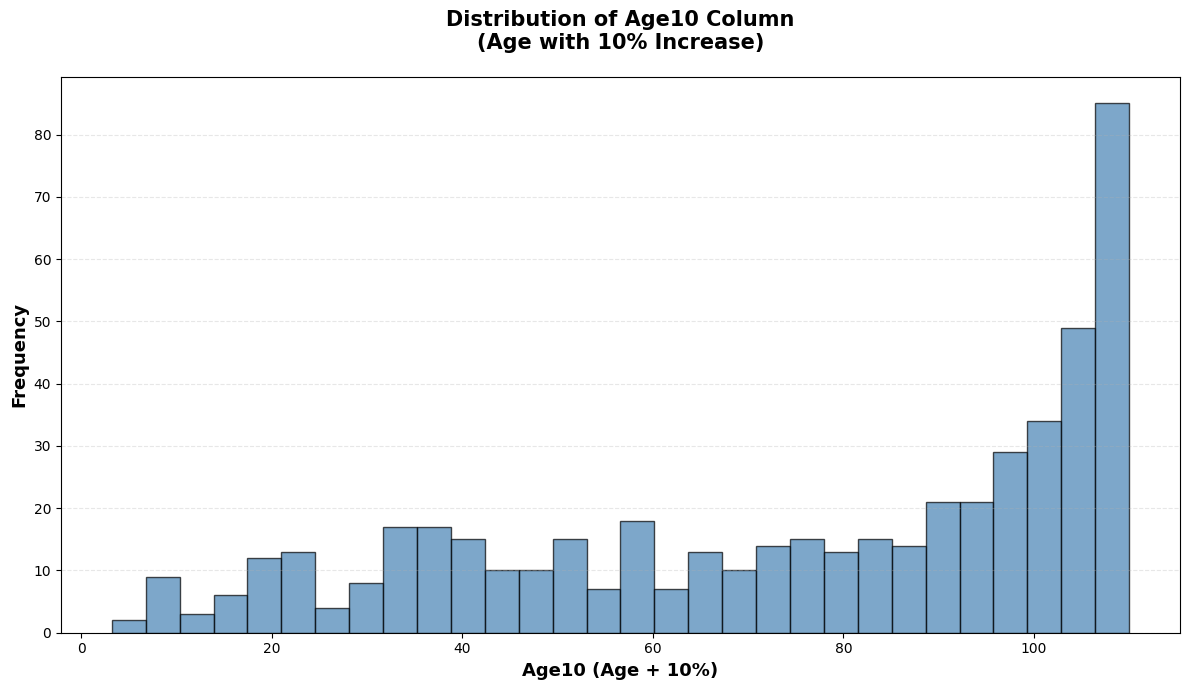

✓ Histogram plotted successfully
   Data points plotted: 506


In [9]:
# ============================================================================
# TASK 8: Plot histogram of Age10 column
# ============================================================================
print("\n" + "="*80)
print("TASK 8: Create Histogram for Age10 Column")
print("="*80)

# Collect Age10 data
age10_data = df.select("Age10").rdd.flatMap(lambda x: x).collect()

# Create histogram
plt.figure(figsize=(12, 7))
plt.hist(age10_data, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Age10 (Age + 10%)', fontsize=13, fontweight='bold')
plt.ylabel('Frequency', fontsize=13, fontweight='bold')
plt.title('Distribution of Age10 Column\n(Age with 10% Increase)',
          fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("✓ Histogram plotted successfully")
print(f"   Data points plotted: {len(age10_data)}")

In [10]:
# ============================================================================
# TASK 9: Summary Statistics
# ============================================================================
print("\n" + "="*80)
print("TASK 9: Summary Statistics")
print("="*80)

print("\nBasic Statistics (describe):")
df.describe().show()

print("\nDetailed Summary Statistics:")
df.summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()


TASK 9: Summary Statistics

Basic Statistics (describe):
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|             lstat|              medv|             Age10|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|            

In [11]:
# ============================================================================
# TASK 10: Convert to Pandas and show last 5 rows
# ============================================================================
print("\n" + "="*80)
print("TASK 10: Convert to Pandas DataFrame")
print("="*80)

pandas_df = df.toPandas()
print(f"✓ Successfully converted Spark DataFrame to Pandas DataFrame")
print(f"   Shape: {pandas_df.shape[0]} rows × {pandas_df.shape[1]} columns")

print("\nLast 5 rows of Pandas DataFrame:")
print(pandas_df.tail())


TASK 10: Convert to Pandas DataFrame
✓ Successfully converted Spark DataFrame to Pandas DataFrame
   Shape: 506 rows × 14 columns

Last 5 rows of Pandas DataFrame:
        crim   zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
501  0.06263  0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273     21.0   
502  0.04527  0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273     21.0   
503  0.06076  0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273     21.0   
504  0.10959  0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273     21.0   
505  0.04741  0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273     21.0   

     lstat  medv   Age10  
501   9.67  22.4   76.01  
502   9.08  20.6   84.37  
503   5.64  23.9  100.10  
504   6.48  22.0   98.23  
505   7.88  11.9   88.88  


In [12]:
# ============================================================================
# BONUS: Data Quality Check
# ============================================================================
print("\n" + "="*80)
print("BONUS: Data Quality Analysis")
print("="*80)
print(f"Total observations: {pandas_df.shape[0]}")
print(f"Total features: {pandas_df.shape[1]}")
print(f"\nData types:")
print(pandas_df.dtypes)
print(f"\nMissing values per column:")
missing = pandas_df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values detected!")
else:
    print(missing[missing > 0])

# ============================================================================
# CLEANUP
# ============================================================================
print("\n" + "="*80)
print("CLEANUP")
print("="*80)
spark.stop()
print("✓ Spark session stopped")
print("\n" + "="*80)
print("ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*80)


BONUS: Data Quality Analysis
Total observations: 506
Total features: 14

Data types:
crim       float64
zn         float64
indus      float64
chas         int32
nox        float64
rm         float64
age        float64
dis        float64
rad          int32
tax          int32
ptratio    float64
lstat      float64
medv       float64
Age10      float64
dtype: object

Missing values per column:
✓ No missing values detected!

CLEANUP
✓ Spark session stopped

ALL TASKS COMPLETED SUCCESSFULLY!
